## «Дистрибутивная семантика (word2vec, GloVe, AdaGram). WMD»

### Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: “теплое пиво” – это плохо, а “теплый свитер” – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье [Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora](https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

---
- Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
- Обучите по коллекции предложений word2vec

- Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    -     тест на определение ближайших слов
    -     тест на аналогии (мужчина – король : женщина – королева)
    -     тест на определение лишнего слова.

- Постройте несколько визуализаций:
    -     TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    -     задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.
---

Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [59]:
import json
import bz2
import regex
import pickle
import re
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm import tqdm
from collections import Counter
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to /Users/aleksandr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.

In [2]:
responses = []
with bz2.BZ2File('/Users/aleksandr/Downloads/nlp-netology-master 2/4/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:49, 1838.41it/s]


In [3]:
df = pd.DataFrame(responses)
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.


In [7]:
# разбивка текста по предложениям
sentenses = []
for text in tqdm(df.text):
    for sent in sent_tokenize(text):
        sentenses.append(sent)

100%|██████████| 153499/153499 [01:52<00:00, 1364.14it/s]


In [169]:
# предобработка текста оставляем только буквы
regex = re.compile("[А-ЯЁа-яё]+")
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text)).replace('ё','е').replace('Ё','Е')
    except:
        return ""

    
# фильтруем текст по стопам
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'т', 'д','вы', 'г']
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
# лематизируем текст
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

    
# удаляем лишние лемы по стопам
mystoplemmas = stopwords.words('russian') + [
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'г', 'п', 'ом', 'ч',
    'з', 'р', 'е', 'эдак', 'уэк', 'уос', 'ка', 'ибо', 'орс', 'кко', 'ки']
def remove_stoplemmas(text, mystopwords=mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
# функция запуска предобработки
def preprocessing(text):
    words = words_only(text)
    no_stopwords = remove_stopwords(words)
    lemmas = lemmatize(no_stopwords)
    no_stoplemmas = remove_stoplemmas(lemmas)
    return(no_stoplemmas)

In [19]:
# формируем разделенные предложения из лемов в новую переменную, для дальнейшей работы
sentenses_lemma=[]
for sent in tqdm(sentenses[:]):
    sentenses_lemma.append(preprocessing(sent).split())

100%|██████████| 2664456/2664456 [25:48<00:00, 1720.62it/s] 


In [21]:
print(sentenses_lemma[:10])

[['добрый', 'день'], ['являться', 'клиент', 'банк', 'поручитель', 'кредитный', 'договор', 'являться', 'либо', 'лицо', 'письменно', 'оформлять', 'отношение', 'банк', 'повод', 'урегулирование', 'чей', 'либо', 'задолженность'], ['начинать', 'марта', 'год', 'начинать', 'приходить', 'бесконечный', 'письмо', 'ооо', 'примо', 'коллект', 'адрес', 'город', 'москва', 'уваровский', 'переулок', 'дом', 'квартира', 'угроза', 'возбуждение', 'уголовный', 'дело', 'отношение', 'гражданин', 'филиппов', 'эдуард', 'владимирович', 'уклоняться', 'уплата', 'взять', 'кредит', 'договор', 'год', 'договор', 'год'], ['весь', 'ответственность', 'хотеть', 'заверять', 'вышеуказанный', 'гражданин', 'разыскивать', 'знакомый', 'адрес', 'зарегистрировать'], ['образ', 'удостоверяться', 'подлинность', 'документ', 'оформлять', 'имя', 'кредитный', 'договор', 'меньший', 'мера', 'понятно', 'почему', 'ваш', 'милость', 'должный', 'переживать', 'бояться', 'имущество'], ['письмо', 'доставлять', 'серьезный', 'неудобство', 'нарушать'

#### Обучите по коллекции предложений word2vec

In [49]:
%time
model_w2v = Word2Vec(
    sentenses_lemma,
    size=300, 
    window=5,
    min_count=20, 
    workers=12,
    sg=True
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 31 µs


#### Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
-     тест на определение ближайших слов
-     тест на аналогии (мужчина – король : женщина – королева)
-     тест на определение лишнего слова.

**тест на определение ближайших слов**

In [54]:
display(model_w2v.wv.most_similar('вклад'))
display(model_w2v.wv.most_similar('кредит'))
display(model_w2v.wv.most_similar('клиент'))

[('депозит', 0.8467650413513184),
 ('рантье', 0.6670635938644409),
 ('дальновидный', 0.6430419683456421),
 ('чемпион', 0.6302051544189453),
 ('супервклад', 0.6259967088699341),
 ('клад', 0.6219824552536011),
 ('несгораемый', 0.6193826794624329),
 ('смартвклад', 0.5980536341667175),
 ('депозитный', 0.5965474247932434),
 ('довложение', 0.5930510759353638)]

[('автокредит', 0.6889339685440063),
 ('потребкредит', 0.6732498407363892),
 ('автокред', 0.6434860229492188),
 ('потреба', 0.6346465349197388),
 ('потребительский', 0.6311368942260742),
 ('ипотека', 0.5918130874633789),
 ('евроремонт', 0.5851523876190186),
 ('ссуда', 0.5740346312522888),
 ('быстрокредит', 0.5616915225982666),
 ('нецелевой', 0.542073130607605)]

[('вкладчик', 0.5659472942352295),
 ('клиентура', 0.5148701667785645),
 ('клиенто', 0.5070213079452515),
 ('клиентка', 0.5059094429016113),
 ('отваживать', 0.4818783402442932),
 ('фанат', 0.4754187762737274),
 ('скотский', 0.4751307964324951),
 ('неклиент', 0.472221314907074),
 ('организованность', 0.46776506304740906),
 ('проситель', 0.4649070203304291)]

**тест на аналогии**

In [58]:
display(model_w2v.most_similar(positive=['рубль', 'доллар'], negative=['российский']))
display(model_w2v.most_similar(positive=['заемщик', 'вклад'], negative=['кредит']))
display(model_w2v.most_similar(positive=['кредит', 'автомобиль'], negative=['квартира']))

[('евро', 0.656276285648346),
 ('руб', 0.6081280708312988),
 ('бакс', 0.5685371160507202),
 ('долл', 0.5620529651641846),
 ('евроцент', 0.5560696721076965),
 ('тысяча', 0.55257248878479),
 ('уе', 0.540740966796875),
 ('дол', 0.5347589254379272),
 ('злотый', 0.5215659141540527),
 ('девятнадцать', 0.5188528895378113)]

[('вкладчик', 0.5606116652488708),
 ('депозит', 0.46327006816864014),
 ('депозитный', 0.4052261710166931),
 ('причисление', 0.4049850106239319),
 ('капитализация', 0.39673686027526855),
 ('супервклад', 0.39225584268569946),
 ('капитализироваться', 0.3904528021812439),
 ('капитализировать', 0.3759385645389557),
 ('неснижать', 0.3749690651893616),
 ('востребование', 0.37496599555015564)]

[('автокредит', 0.6322134137153625),
 ('автокред', 0.5218568444252014),
 ('потребительский', 0.5166386365890503),
 ('евроремонт', 0.5154536366462708),
 ('потребкредит', 0.488505482673645),
 ('пежо', 0.4841212034225464),
 ('потреба', 0.4839259684085846),
 ('спецпрограмма', 0.4781467318534851),
 ('фольксваген', 0.47528374195098877),
 ('форд', 0.469152569770813)]

**тест на определение лишнего слова**

In [55]:
display(model_w2v.doesnt_match("деньги доллар кошка".split()))
display(model_w2v.doesnt_match("стол стул деньги".split()))
display(model_w2v.doesnt_match("клиент вкладчик банк".split()))

'кошка'

'деньги'

'банк'

#### Постройте несколько визуализаций:
-     TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
-     задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. 

Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

**TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов**

In [60]:
fd = FreqDist()
top_words = []

for text in sentenses_lemma:
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])

In [65]:
print(len(top_words), '\n')
print(top_words[:100])

500 

['банк', 'карта', 'деньги', 'день', 'кредит', 'отделение', 'счет', 'клиент', 'сотрудник', 'сказать', 'сумма', 'получать', 'заявление', 'год', 'вопрос', 'время', 'приходить', 'кредитный', 'ответ', 'платеж', 'вклад', 'офис', 'данный', 'телефон', 'договор', 'ваш', 'номер', 'звонить', 'банкомат', 'сбербанк', 'очень', 'позвонить', 'месяц', 'написать', 'проблема', 'обращаться', 'решать', 'работать', 'средство', 'рубль', 'работа', 'документ', 'ситуация', 'звонок', 'отвечать', 'говорить', 'человек', 'хотеть', 'операция', 'почему', 'давать', 'информация', 'сообщать', 'сделать', 'смс', 'оформлять', 'срок', 'услуга', 'просто', 'знать', 'должный', 'заявка', 'обслуживание', 'очередь', 'банка', 'минута', 'ждать', 'сегодня', 'первый', 'девушка', 'сайт', 'руб', 'претензия', 'просить', 'новый', 'интернет', 'процент', 'принимать', 'выдавать', 'снимать', 'неделя', 'открывать', 'никакой', 'оператор', 'являться', 'весь', 'понимать', 'становиться', 'проходить', 'закрывать', 'предлагать', 'оплачивать',

In [66]:
top_words_vec = model_w2v[top_words]
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [67]:
# https://docs.bokeh.org/en/latest/
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(
    tools="pan,wheel_zoom,reset,save",
    toolbar_location="above",
    title="word2vec T-SNE for most common words")

source = ColumnDataSource(
    data=dict(
        x1=top_words_tsne[:,0],
        x2=top_words_tsne[:,1],
        names=top_words))

p.scatter(
    x="x1", 
    y="x2", 
    size=8, 
    source=source)

labels = LabelSet(
    x="x1", 
    y="x2", 
    text="names", 
    y_offset=6,
    text_font_size="6pt", 
    text_color="#555555",
    source=source, 
    text_align='center')

p.add_layout(labels)
show(p)

Loading BokehJS ...

**Посмотрим подробнее на скопления**

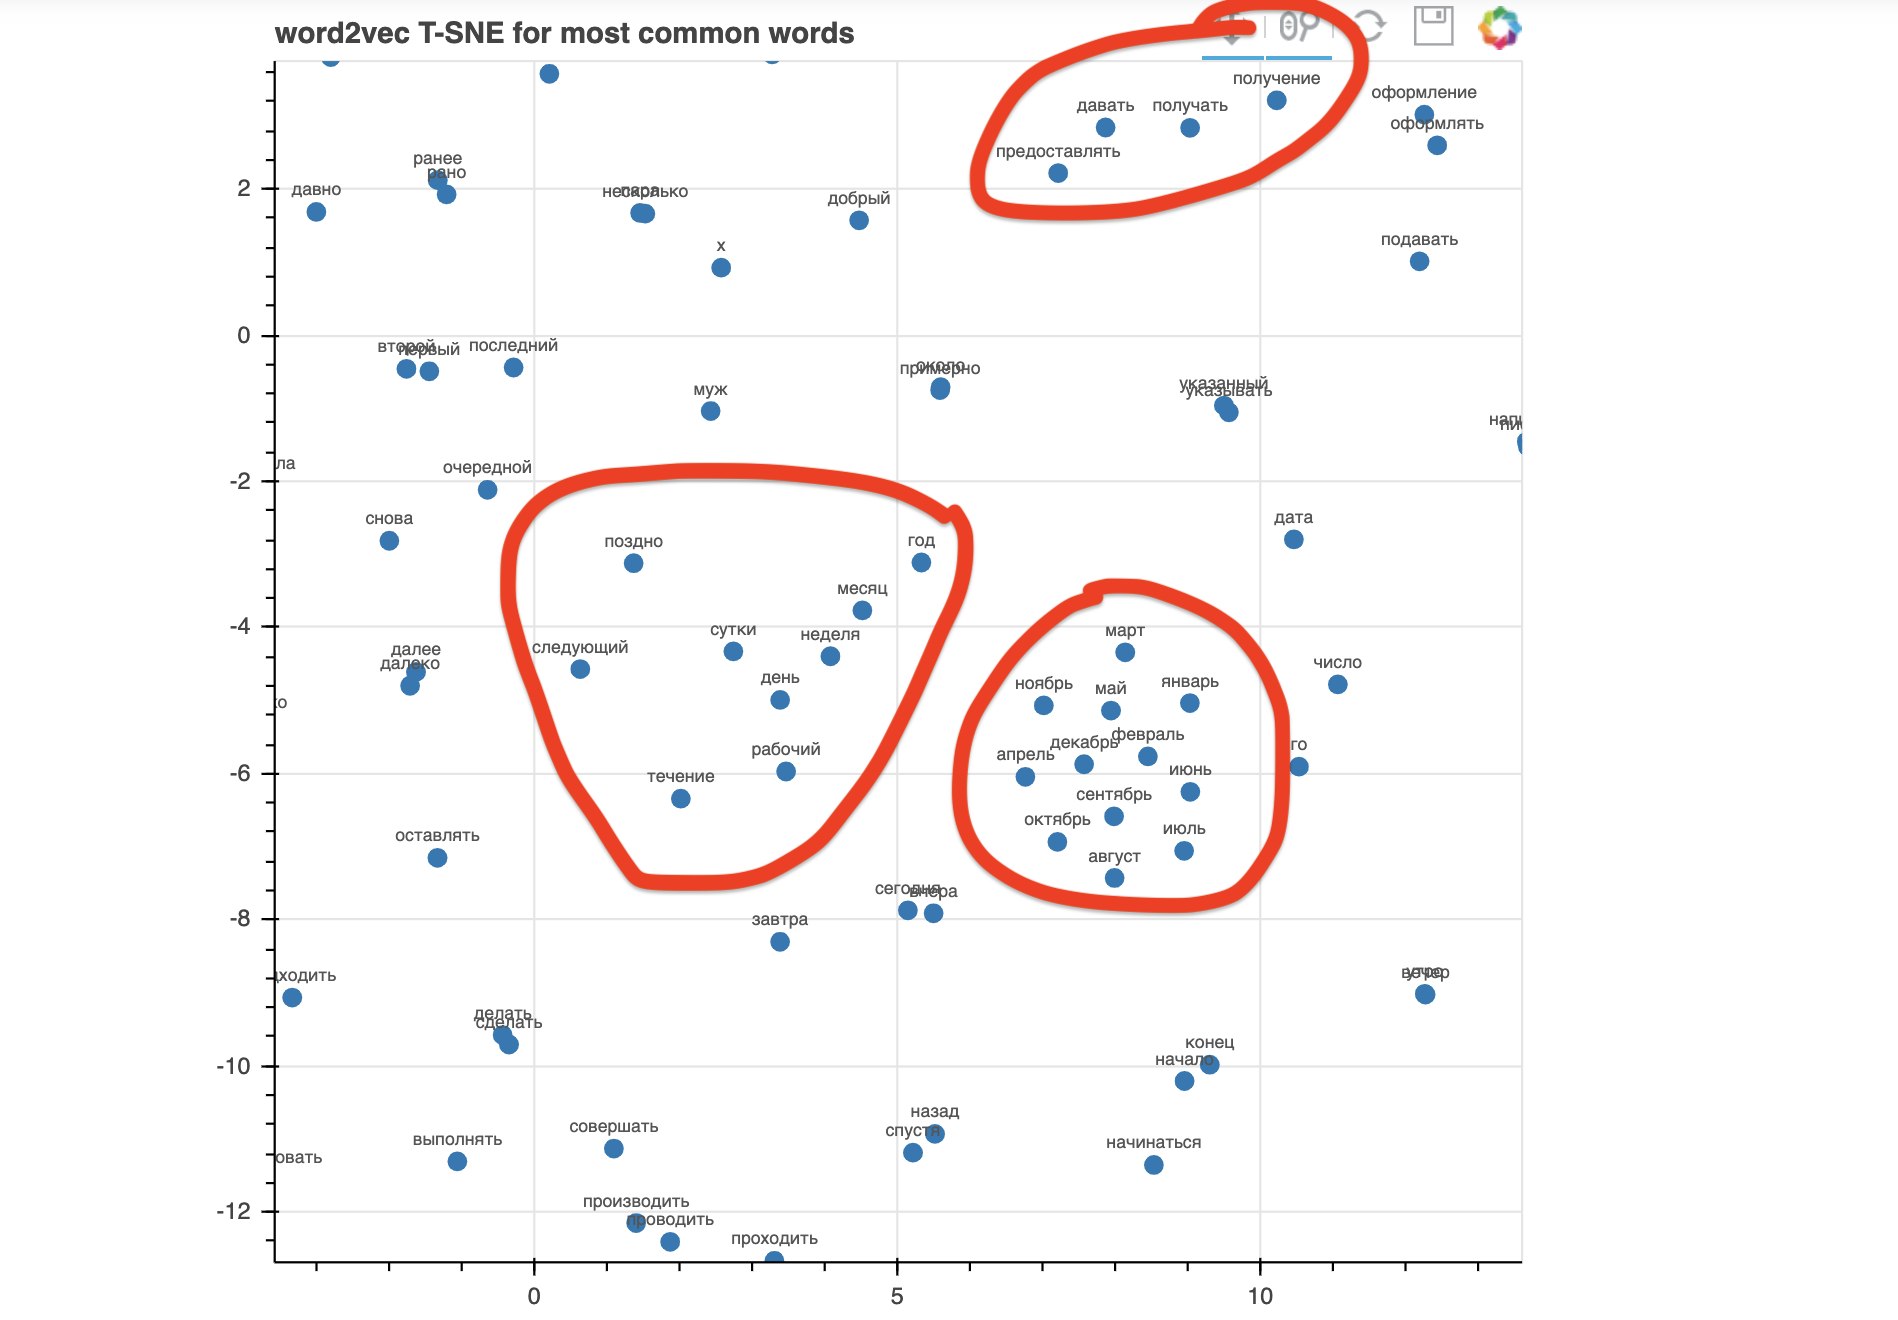

In [69]:
from IPython.display import Image
Image("Screenshot1.png")

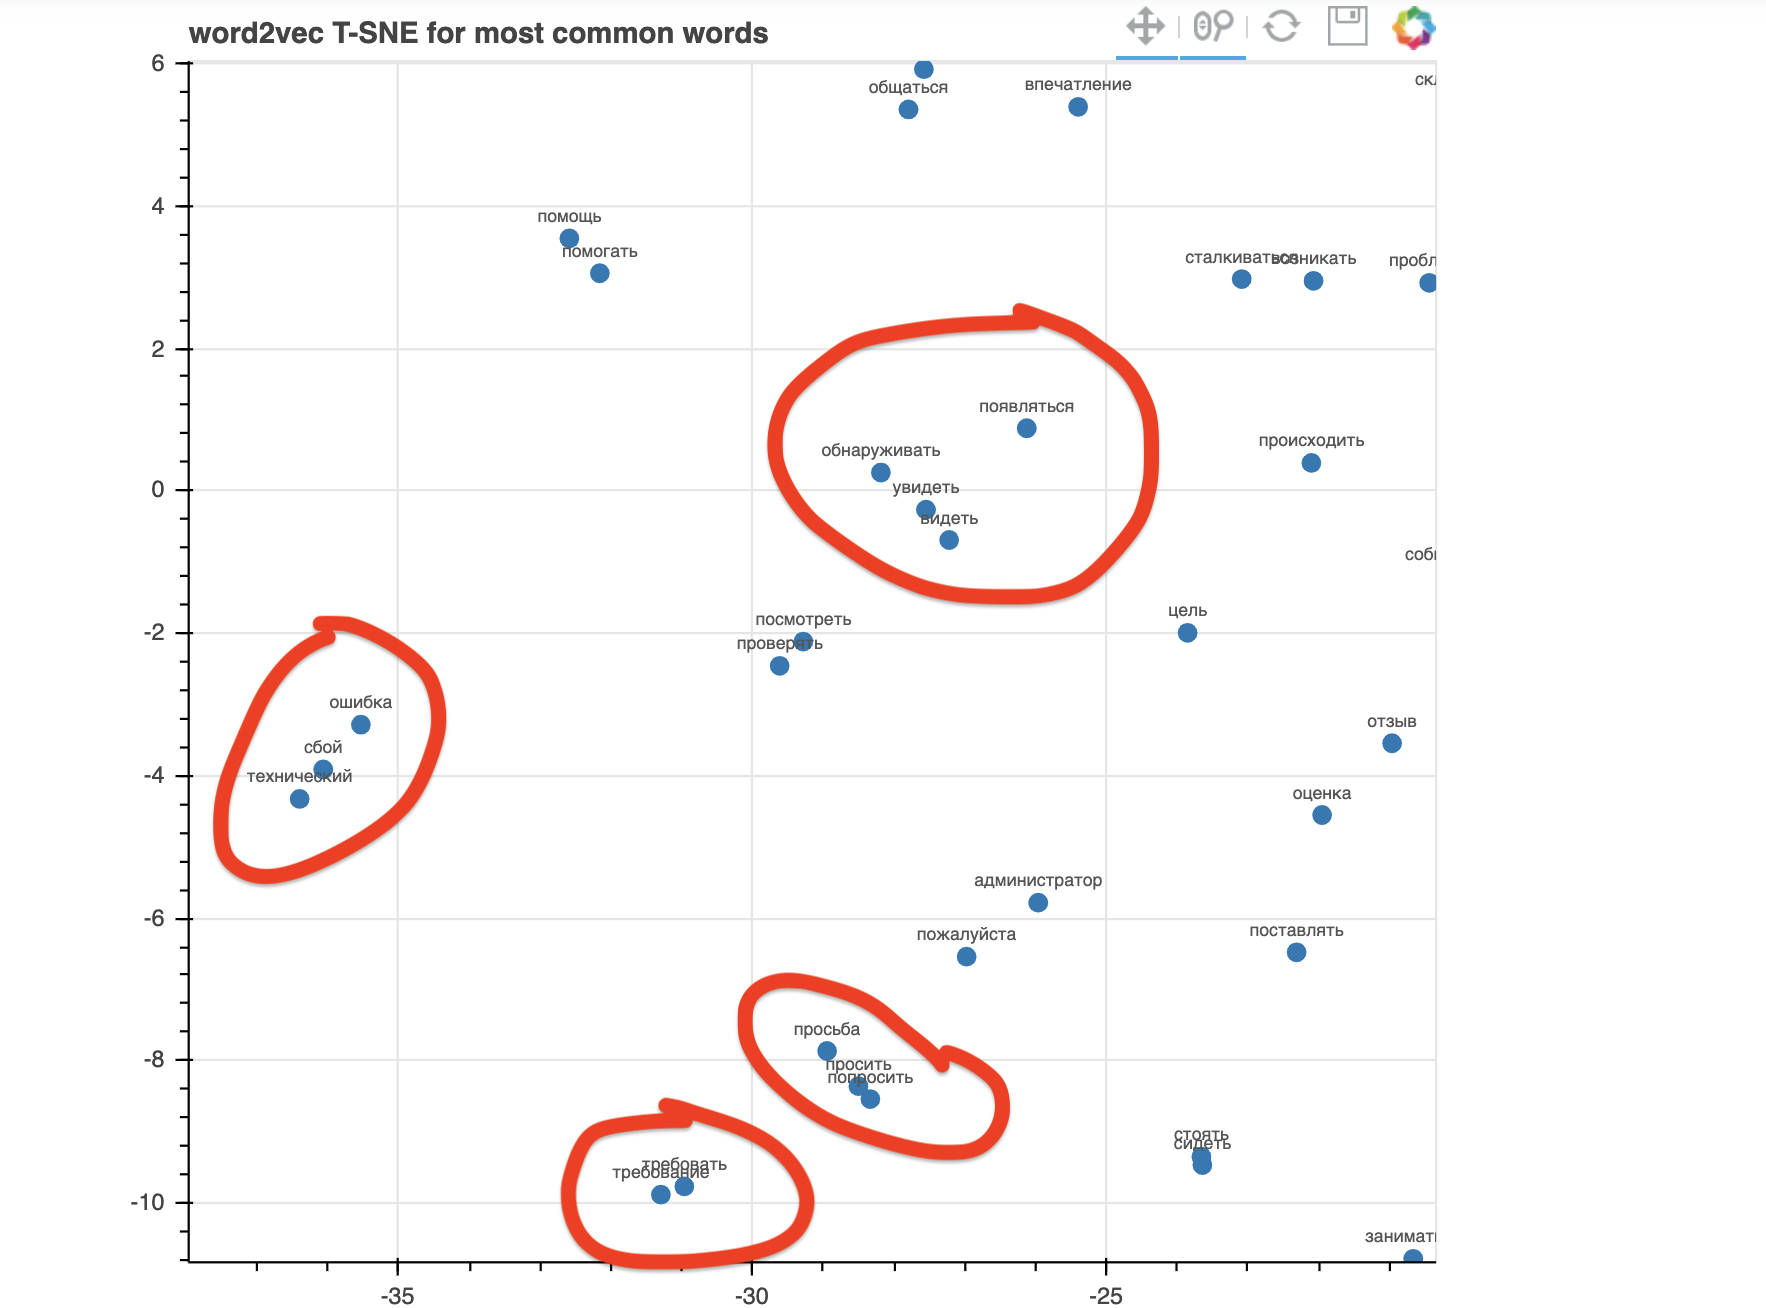

In [70]:
Image("Screenshot2.png")

**_Получились довольно логичные скопления, выше выделены некоторые из них_**

#### Задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.

Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [71]:
xp = model_w2v['хороший'] - model_w2v['плохо']
bm = model_w2v['быстро'] - model_w2v['медленно']

In [170]:
data = df.copy()
data.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


In [186]:
bank_name=data.bank_name.value_counts(normalize=1).index.tolist()[:15] # топ 15 
bank_name=[preprocessing(bank.lower()).split()[0] for bank in bank_name ] # предобработка
bank_name

['сбербанк',
 'альфа',
 'втб',
 'русский',
 'хоум',
 'тинькофф',
 'национальный',
 'ренессанс',
 'связной',
 'отп',
 'восточный',
 'райффайзенбанк',
 'московский',
 'ситибанк',
 'авангард']

In [187]:
df_bank = pd.DataFrame(bank_name, columns=['bank_name'])

In [188]:
df_bank['X'] = df_bank.apply(
    lambda row:np.dot(model_w2v[row['bank_name']], xp), axis=1)

df_bank['Y'] = df_bank.apply(
    lambda row:np.dot(model_w2v[row['bank_name']], bm), axis=1)

In [189]:
df_bank.head(15)

,bank_name,X,Y
0,сбербанк,0.585764,-0.483231
1,альфа,1.114417,0.659119
2,втб,0.522703,0.641254
3,русский,0.252882,0.074312
4,хоум,1.897472,0.993153
5,тинькофф,1.459979,0.448412
6,национальный,0.541221,-0.368663
7,ренессанс,0.600024,1.021178
8,связной,1.250896,-0.708569
9,отп,0.558083,0.394437


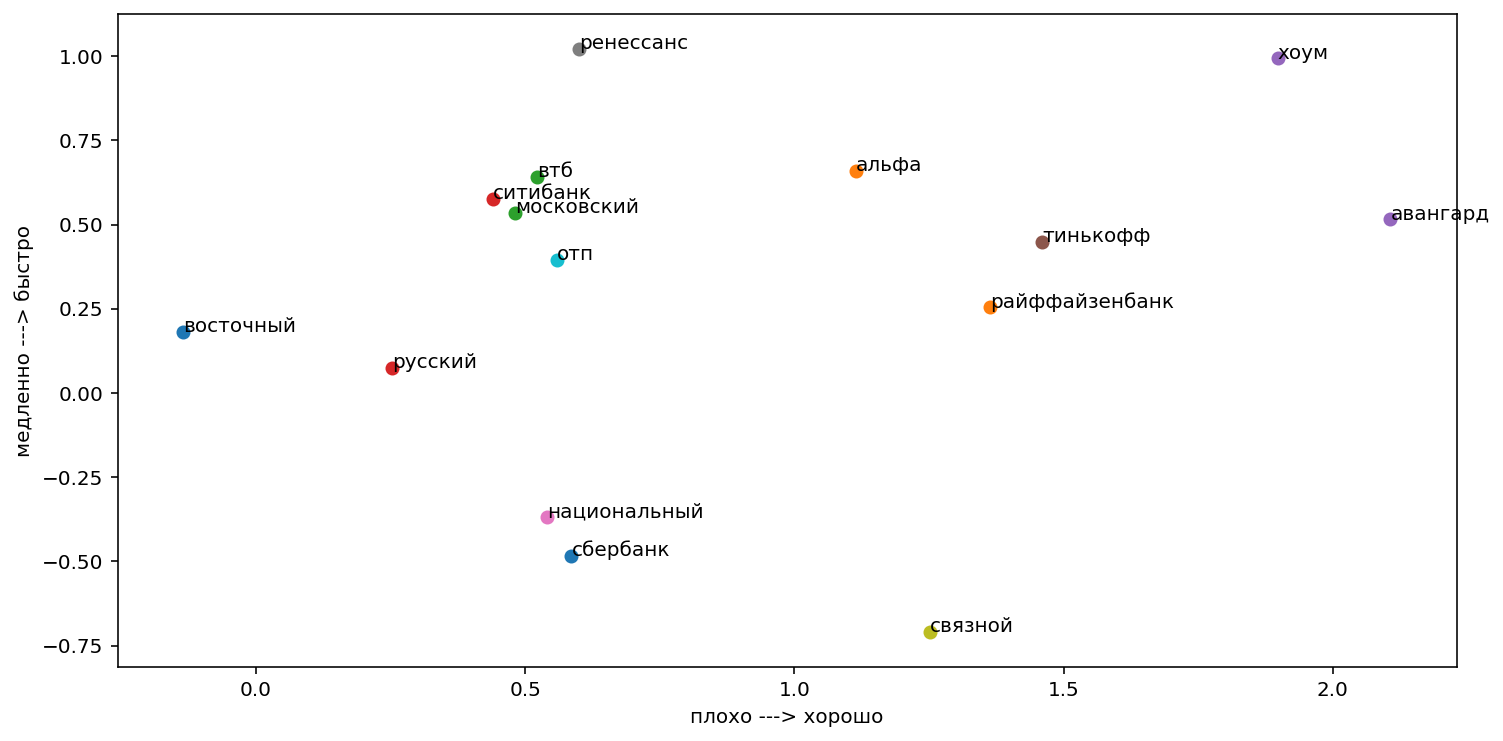

In [190]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)

for i in range(len(df_bank)):
    x, y, text = df_bank.iloc[i]['X'], df_bank.iloc[i]['Y'], df_bank.iloc[i]['bank_name']
    ax.scatter(x, y)
    ax.text(x, y, text)

ax.set_xlabel('плохо ---> хорошо')
ax.set_ylabel('медленно ---> быстро')

plt.show()

In [192]:
output_notebook()

p = figure(
    tools="pan,wheel_zoom,reset,save",
    toolbar_location="above",
    title="word2vec T-SNE for most common words")

source = ColumnDataSource(
    data=dict(
        x1=df_bank.X,
        x2=df_bank.Y,
        names=df_bank.bank_name))

p.scatter(x="x1", y="x2", size=10, source=source)

labels = LabelSet(
    x="x1", 
    y="x2", 
    text="names", 
    y_offset=6,
    text_font_size="9pt", 
    text_color="#555555",
    source=source, 
    text_align='center')

p.add_layout(labels)
p.xaxis.axis_label = 'плохо ---> хорошо'
p.yaxis.axis_label = 'медленно ---> быстро'
show(p)

Loading BokehJS ...

#### Итого:
- Самый быстрый **"Ренессанс"**
- Самый медленный **"Связной"**
- Самый хороший **"Авангард"**
- Самый плохой **"Восточный"**

Стоит помниль, что данные не семплированы, т.е. у 'Сбера' м.б. 1000+ отзывов,\
а у 'Восточный' 100+, что влияет на конечный результат.

In [ ]:
pass